# **Considering Punctuations**

# Read the Spam collection dataset

In [1]:
import pandas as pd
sms_spam_collection = pd.read_csv('SMSSpamCollection', sep = '\t', header=None, names = ['Label', 'SMS'])

In [2]:
sms_spam_collection.shape

(5572, 2)

In [3]:
sms_spam_collection.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Estimate of Messages per labels

In [4]:
sms_spam_collection['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

# Rename the labels :
  * ham -> NS
  * spam-> S

In [5]:
sms_spam_collection['Label']=sms_spam_collection['Label'].replace(['ham','spam'],['NS','S'])

In [6]:
sms_spam_collection.head()

,Label,SMS
0,NS,"Go until jurong point, crazy.. Available only ..."
1,NS,Ok lar... Joking wif u oni...
2,S,Free entry in 2 a wkly comp to win FA Cup fina...
3,NS,U dun say so early hor... U c already then say...
4,NS,"Nah I don't think he goes to usf, he lives aro..."


# The formula that we will be using to calculate the probabilities is :
  * P(S| w1 w2 w3...wn) ~ P(S) P(w1 | S) P( w2 | S)......P(wn | S)
  * P(NS| w1 w2 w3...wn) ~ P(NS) P(w1 |NS) P( w2 |NS)......P(wn |NS)

P(W n | spam) = ( N wn |spam alpha) / (N spam) (N vocab * alpha)

  * N wn = The number of times the word occurs in the spam message
  * alpha = 1 (smoothing parameter)
  * N spam = The total number of words in the spam messages
  * N vocab = The total number of words in the vocabulary

# Preprocessing

In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Lower Case

In [8]:
sms_spam_collection['SMS'] = sms_spam_collection['SMS'].str.lower()

## Make a bag of word and count the frequncy of the word 

In [9]:
all_words = []
for index, row in sms_spam_collection.iterrows():
    for word in word_tokenize(row['SMS']):
        all_words.append(word.lower())
all_words = nltk.FreqDist(all_words)

In [10]:
type(all_words)

nltk.probability.FreqDist

In [11]:
len(all_words)

9837

# Creating vocabulary of words appearing more than 100 times in corpus.

**(Punctuations are being considered)**

In [12]:
vocab=[]
for c,n in list(all_words.items()):
  if n>=100:
    vocab.append(c)

In [13]:
my_dict={}
for c,n in list(all_words.items()):
  if n>=100:
    my_dict[c]=n
pd.DataFrame(data=my_dict.values(),index=my_dict.keys(),columns=['freq']).sort_values('freq',ascending=False)[0:15]

,freq
.,4777
i,2905
to,2252
you,2234
",",1938
?,1550
a,1439
!,1397
the,1336
...,1261


# Make a documents that contains tokenized words and labels

In [14]:
lst_token= []   
for index, row in sms_spam_collection.iterrows():
    lst_token.append((word_tokenize(row['SMS']),row['Label']))

# Make a feature set that shows which word was in the word_features

In [15]:
def find_features(vocabulary,document):
    words = set(document)
    features = {}
    for w in vocabulary: # 100 frequent words
        features[w] = (w in words) # True/False
    return features

In [16]:
featuresets = [(find_features(vocab,message), label) for (message, label) in lst_token]

In [17]:
featuresets[0]

({'!': False,
  '#': False,
  '&': False,
  "''": False,
  "'ll": False,
  "'m": False,
  "'s": False,
  '(': False,
  ')': False,
  ',': True,
  '-': False,
  '.': False,
  '...': True,
  '2': False,
  '4': False,
  ':': False,
  ';': False,
  '?': False,
  '``': False,
  'a': False,
  'about': False,
  'all': False,
  'am': False,
  'an': False,
  'and': False,
  'any': False,
  'are': False,
  'as': False,
  'at': False,
  'back': False,
  'be': False,
  'been': False,
  'but': False,
  'by': False,
  'c': False,
  'call': False,
  'can': False,
  'claim': False,
  'come': False,
  'd': False,
  'da': False,
  'day': False,
  'dear': False,
  'did': False,
  'do': False,
  'dont': False,
  'for': False,
  'free': False,
  'from': False,
  'get': False,
  'give': False,
  'go': True,
  'going': False,
  'good': False,
  'got': True,
  'great': True,
  'gt': False,
  'had': False,
  'happy': False,
  'has': False,
  'have': False,
  'he': False,
  'her': False,
  'here': False,
  'hey

# shuffle with the same seed

In [18]:
import random
random.Random(4).shuffle(featuresets)

# Spliting the dataset to the tarin & test set

In [19]:
# divide training set and test set
training_set = featuresets[:round(len(sms_spam_collection) * 0.80)]
testing_set =  featuresets[round(len(sms_spam_collection) * 0.80):]

# sklearn.naive_bayes 

# imporing essential libraries

In [20]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Classify our trainin set using nltk library

In [21]:
NB = nltk.NaiveBayesClassifier.train(training_set)

In [22]:
print(nltk.classify.accuracy(NB , testing_set)*100)

96.85816876122082


         precision    ,                     recall           ,                 fscore         ,         support        => 

(array([0.97427984, 0.92957746]), array([0.98955068, 0.84076433]), array([0.98185588, 0.88294314]), array([957, 157]))

              precision    recall  f1-score   support

          NS       0.97      0.99      0.98       957
           S       0.93      0.84      0.88       157

    accuracy                           0.97      1114
   macro avg       0.95      0.92      0.93      1114
weighted avg       0.97      0.97      0.97      1114



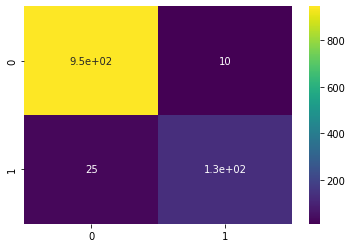

In [23]:
y_pred=[]
y_test=[]
for sample in testing_set:
        y_pred.append(NB.classify(sample[0]))
        y_test.append(sample[1])
print("         precision    ,                     recall           ,                 fscore         ,         support        => \n")
print(f"{precision_recall_fscore_support(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,cmap='viridis');

# Evaluating Accuracy for different ranges of lower-bands.

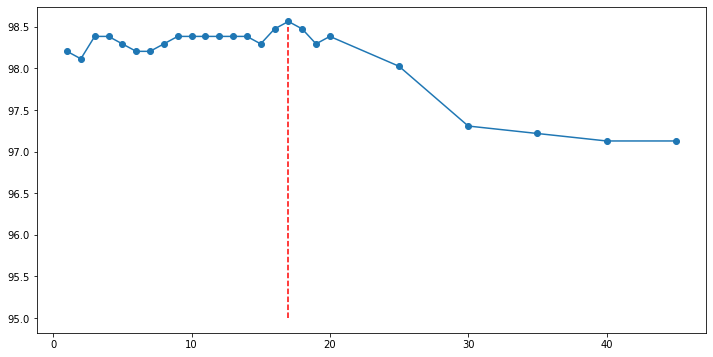

In [25]:
import matplotlib.pyplot as plt
sel=list(range(1,20))+list(range(20,50,5))
Acc=[]
for lb in sel:
  V=[]
  for c,n in list(all_words.items()):
    if n>=lb:
      V.append(c)
  fs = [(find_features(V,M), label) for (M, label) in lst_token]
  random.Random(4).shuffle(fs)
  training_set = fs[:round(len(sms_spam_collection) * 0.80)]
  testing_set =  fs[round(len(sms_spam_collection) * 0.80):]
  NB = nltk.NaiveBayesClassifier.train(training_set)
  Acc.append(nltk.classify.accuracy(NB , testing_set)*100)
plt.figure(figsize=(12,6))
plt.plot(sel,Acc,marker='o')
plt.vlines(sel[Acc.index(max(Acc))],95,98.5,ls='--',color='red')

# **Eliminate Punctuations**

In [ ]:
sms_spam_collection['SMS']

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: SMS, Length: 5572, dtype: object

In [ ]:
import string
for character in string.punctuation:
  sms_spam_collection['SMS'] = sms_spam_collection['SMS'].str.replace(character, '').str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Make a bag of word and count the frequncy of the word 
all_words = []
for index, row in sms_spam_collection.iterrows():
    for word in word_tokenize(row['SMS']):
        all_words.append(word.lower())
all_words = nltk.FreqDist(all_words)

In [ ]:
len(all_words)

9642

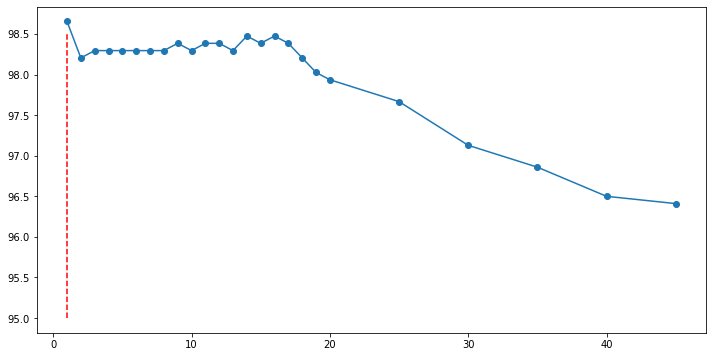

In [ ]:
import matplotlib.pyplot as plt
sel=list(range(1,20))+list(range(20,50,5))
Acc=[]
for lb in sel:
  V=[]
  for c,n in list(all_words.items()):
    if n>=lb:
      V.append(c)
  fs = [(find_features(V,M), label) for (M, label) in lst_token]
  random.Random(4).shuffle(fs)
  training_set = fs[:round(len(sms_spam_collection) * 0.80)]
  testing_set =  fs[round(len(sms_spam_collection) * 0.80):]
  NB = nltk.NaiveBayesClassifier.train(training_set)
  Acc.append(nltk.classify.accuracy(NB , testing_set)*100)
plt.figure(figsize=(12,6))
plt.plot(sel,Acc,marker='o')
plt.vlines(sel[Acc.index(max(Acc))],95,98.5,ls='--',color='red')